# ts_plot

A generalized time series plotting function designed to quickly convey a large amount of information through professional-quality plots.  

In [1]:
%reset
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Dataframes

In [2]:
utqiagvik = pd.read_csv(os.path.join('data', 'USW00027502.csv'), index_col = 0, parse_dates = ['date'])
fair = pd.read_csv(os.path.join('data', 'USW00026411.csv'), index_col = 0, parse_dates = ['date'])
anc = pd.read_csv(os.path.join('data', 'USW00026451.csv'), index_col = 0, parse_dates = ['date'])

### Set the index to the date column

In [3]:
utqiagvik.set_index('date', drop = True, inplace = True)
fair.set_index('date', drop = True, inplace = True)
anc.set_index('date', drop = True, inplace = True)

In [4]:
def ts_plot(df, name, params): 
  
    # Adds start date to dataframe.
    # The start date sets the date from which decades are counted.
    # The start date also filters the dataframe by slicing the dataframe from that date.
    if params['start date'] not in df.index.values:
        df = pd.concat([df, pd.DataFrame( index = [params['start date']])])
    df.sort_index(inplace = True)
    df = df[params['start date']: ]
    
    idx = 0 # column index
    line_labels = [] # array for plot legend 
    dict_keys = params['columns']
    
    # Determine how many subplot columns are needed
    if (len(params['columns']) == 1):
        c = 1
    else:
        c = 2
    
    # defing the figure and axes
    fig, axes = plt.subplots(int(np.ceil(len(params['columns'])/2)), c, figsize=(16,12), squeeze = False)
    
    for i in range(int(np.ceil(len(params['columns'])/2))):
        for j in range(c): 
            daily_flag = False
            element = params['columns'][idx]
            unit = params['units'][idx]
            
            x = df.resample("10AS", closed = "left").count()
            x = x[x[element] > params['min decade records']]
            s_date_decade = x.index.min()
            e_date_decade = x.index.max()
            e_date_decade = e_date_decade.replace(year=e_date_decade.year + 9)

            x_ann = df.resample("1AS", closed = "left").count()
            x_ann = x_ann[x_ann[element] > params['min annual records']]
            s_date_ann = x_ann.index.min()
            e_date_ann = x_ann.index.max()
            e_date_ann = e_date_ann.replace(year=e_date_ann.year, month = 12, day = 31)

            df_ann = df[s_date_ann : e_date_ann]
            df_dec = df[s_date_decade : e_date_decade]

            df_ann = df_ann.resample('1AS').mean()

            df_avg = df_ann[dict_keys].mean()
            if (len(df_dec[element].resample('10AS').mean()) > 1):
                df_dec = df_dec.resample('10AS').mean()

            if (len(df_ann[element]) <= 1):
                axes[i][j].plot(df.index, df[element], color = "blue", label = "Daily")
                line_labels.append("Daily")
                daily_flag = True
            else:
                axes[i][j].plot(df_ann.index, df_ann[element], color = "lightgrey", label = "Annual")
                line_labels.append("Annual")
            if (len(df_dec) > 0):
                df_dec = pd.concat([df_dec, df_dec.loc[s_date_decade].to_frame().T.rename(index = {s_date_decade : s_date_decade.replace(year=s_date_decade.year - 10)})])
                df_dec.sort_index(inplace = True)
                df_dec.index = df_dec.index+ pd.DateOffset(years=10)
                axes[i][j].step(df_dec.index, df_dec[element], color = "black", lw = 3, label = "Decadal")
                line_labels.append("Decadal")
                axes[i][j].hlines(df_avg[element], df_ann.index.min(), df_ann.index.max(), linestyle="dashed", color = "grey", label = "Average")
                line_labels.append("Mean")

            # Removes duplicates from line_labels
            labels = list(dict.fromkeys(line_labels))

            # adds grid lines
            axes[i][j].grid(linestyle='-', linewidth=0.2)
            
            # Controls the y-axis based on the element's range
            # all values are negative
            if df_ann[element].min() < 0 and df_ann[element].max() < 0: 
                axes[i][j].set_ylim(df_ann[element].min() * 1.1, 0)
                if(daily_flag):
                    axes[i][j].set_ylim(df_[element].min() * 1.1, 0)
            # values are positive and negative
            if df_ann[element].min() < 0 and df_ann[element].max() > 0:
                axes[i][j].set_ylim(df_ann[element].min() * 1.1, df_ann[element].max() * 1.1)
                if(daily_flag):
                    axes[i][j].set_ylim(df[element].max() * 1.1, df[element].max() * 1.1)
                
            # all values are positive    
            if df_ann[element].min() > 0 and df_ann[element].max() > 0:
                axes[i][j].set_ylim(df_ann[element].max() * -0.05, df_ann[element].max() * 1.1)
                if(daily_flag):
                    axes[i][j].set_ylim(df[element].max() * -0.05, df[element].max() * 1.1)
                
            axes[i][j].set_title(element.upper(), fontsize = 20)
            axes[i][j].set_ylabel(unit, fontsize = 16)
            if ((idx + 1) < len(params['columns'])):
                idx = idx + 1
    if ((c != 1) and (len(params['columns'])%2 != 0)):
        axes.flat[-1].set_visible(False) # removes last plot


    fig.legend(
        labels=labels,
        loc="center right", 
        borderaxespad=0.1,  
    )

    plt.subplots_adjust(right=.87)
    fig.suptitle(name, fontsize=24)

# Examples

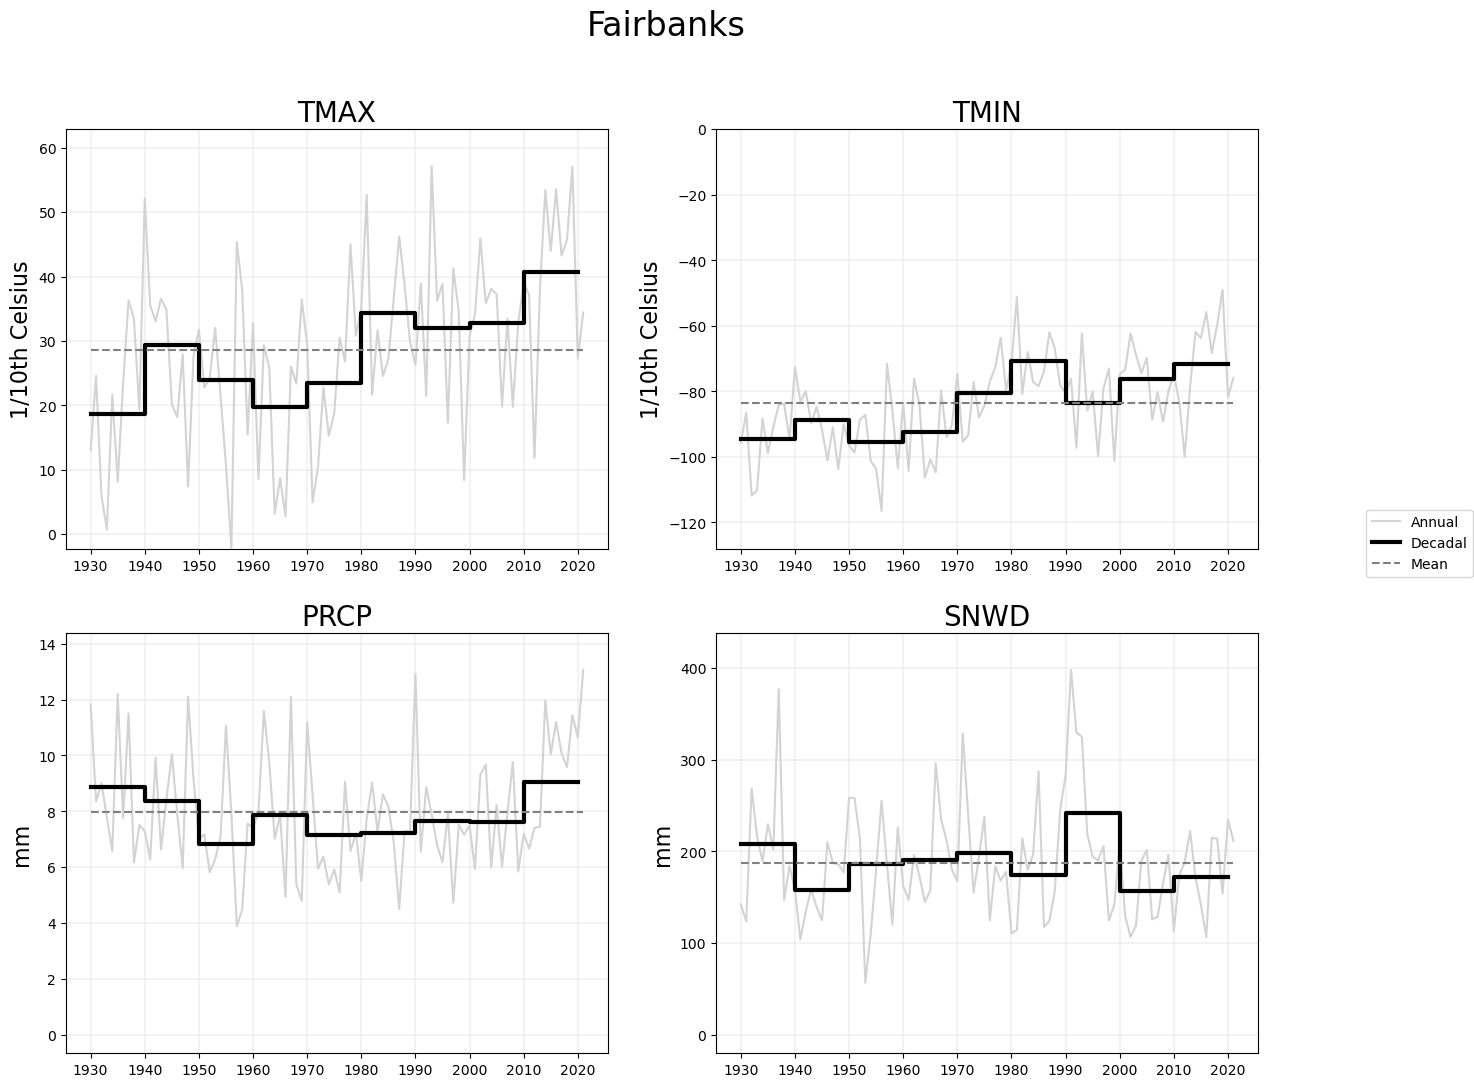

In [5]:
params = {
    'start date': pd.to_datetime("1890-01-01", format="%Y-%m-%d"),
    'columns': ['tmax', 'tmin', 'prcp', 'snwd'],
    'units': ['1/10th Celsius', '1/10th Celsius', 'mm', 'mm'],
    'min decade records': 3000,
    'min annual records': 300
}

ts_plot(fair, "Fairbanks", params)

### Change the start date to 1980-01-01

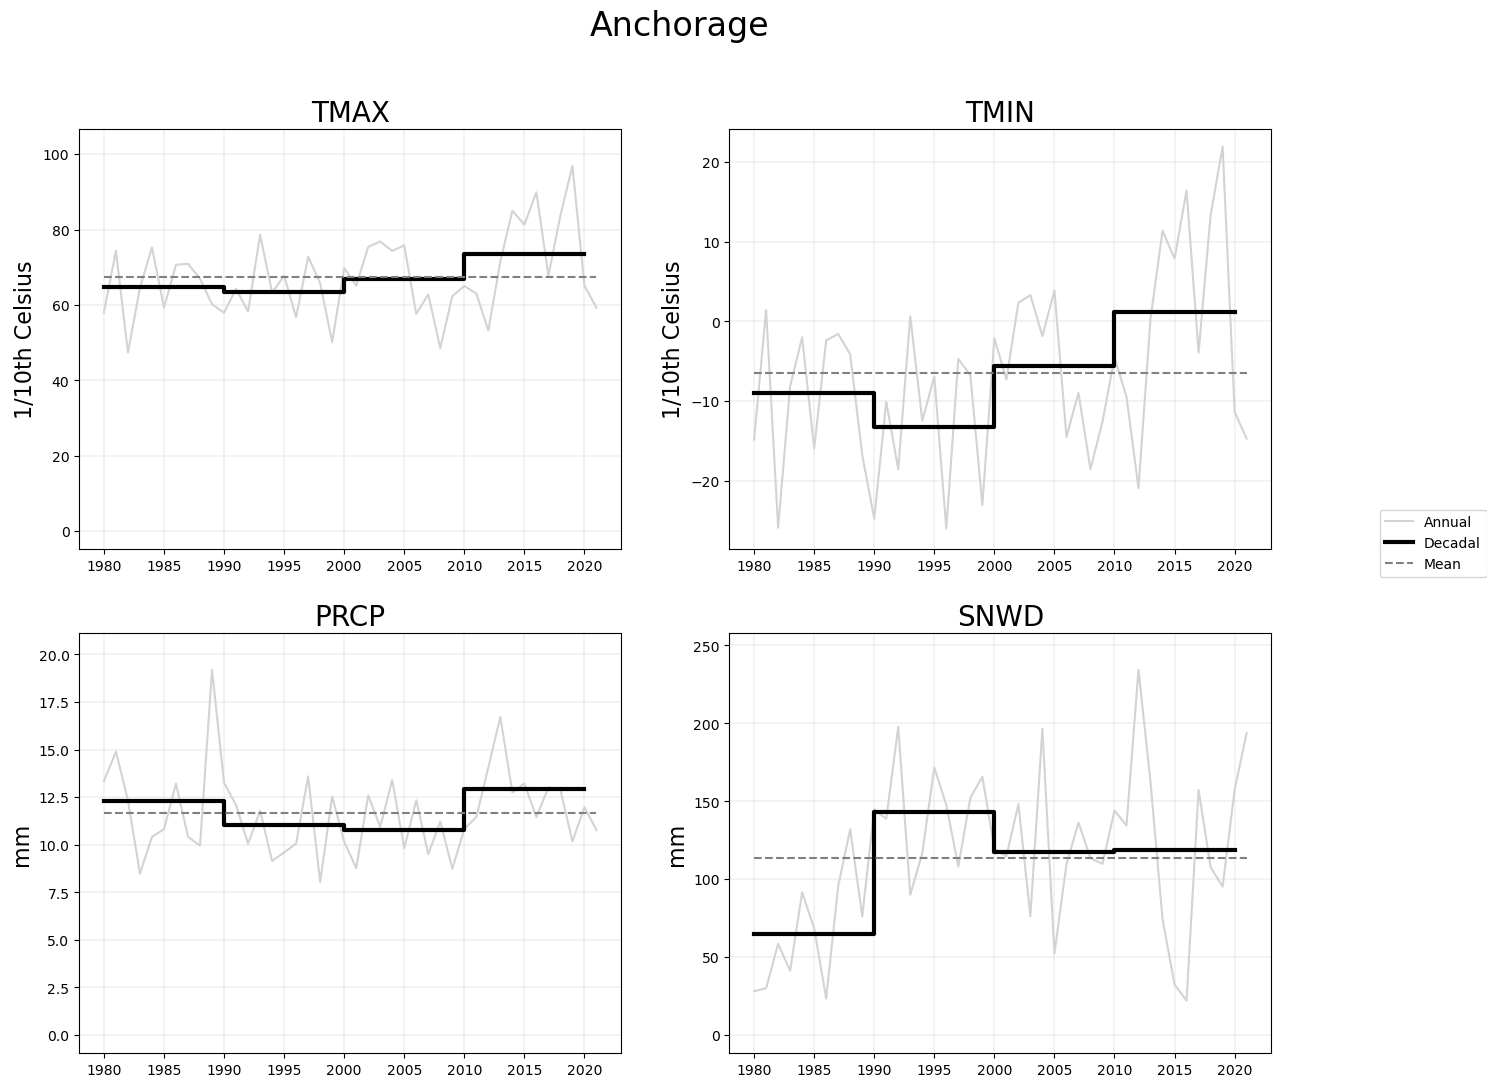

In [6]:
params = {
    'start date': pd.to_datetime("1980-01-01", format="%Y-%m-%d"),
    'columns': ['tmax', 'tmin', 'prcp', 'snwd'],
    'units': ['1/10th Celsius', '1/10th Celsius', 'mm', 'mm'],
    'min decade records': 2920,
    'min annual records': 292
}

ts_plot(anc, "Anchorage", params)

# Arbitrary Data

## Apple Stock from Yahoo Finance

#### https://finance.yahoo.com/quote/AAPL/history?p=AAPL

In [7]:
apple = pd.read_csv(os.path.join('data','AAPL.csv'), parse_dates = ['Date'])
apple = apple.dropna()
apple.set_index("Date", inplace = True)
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


### One Parameter

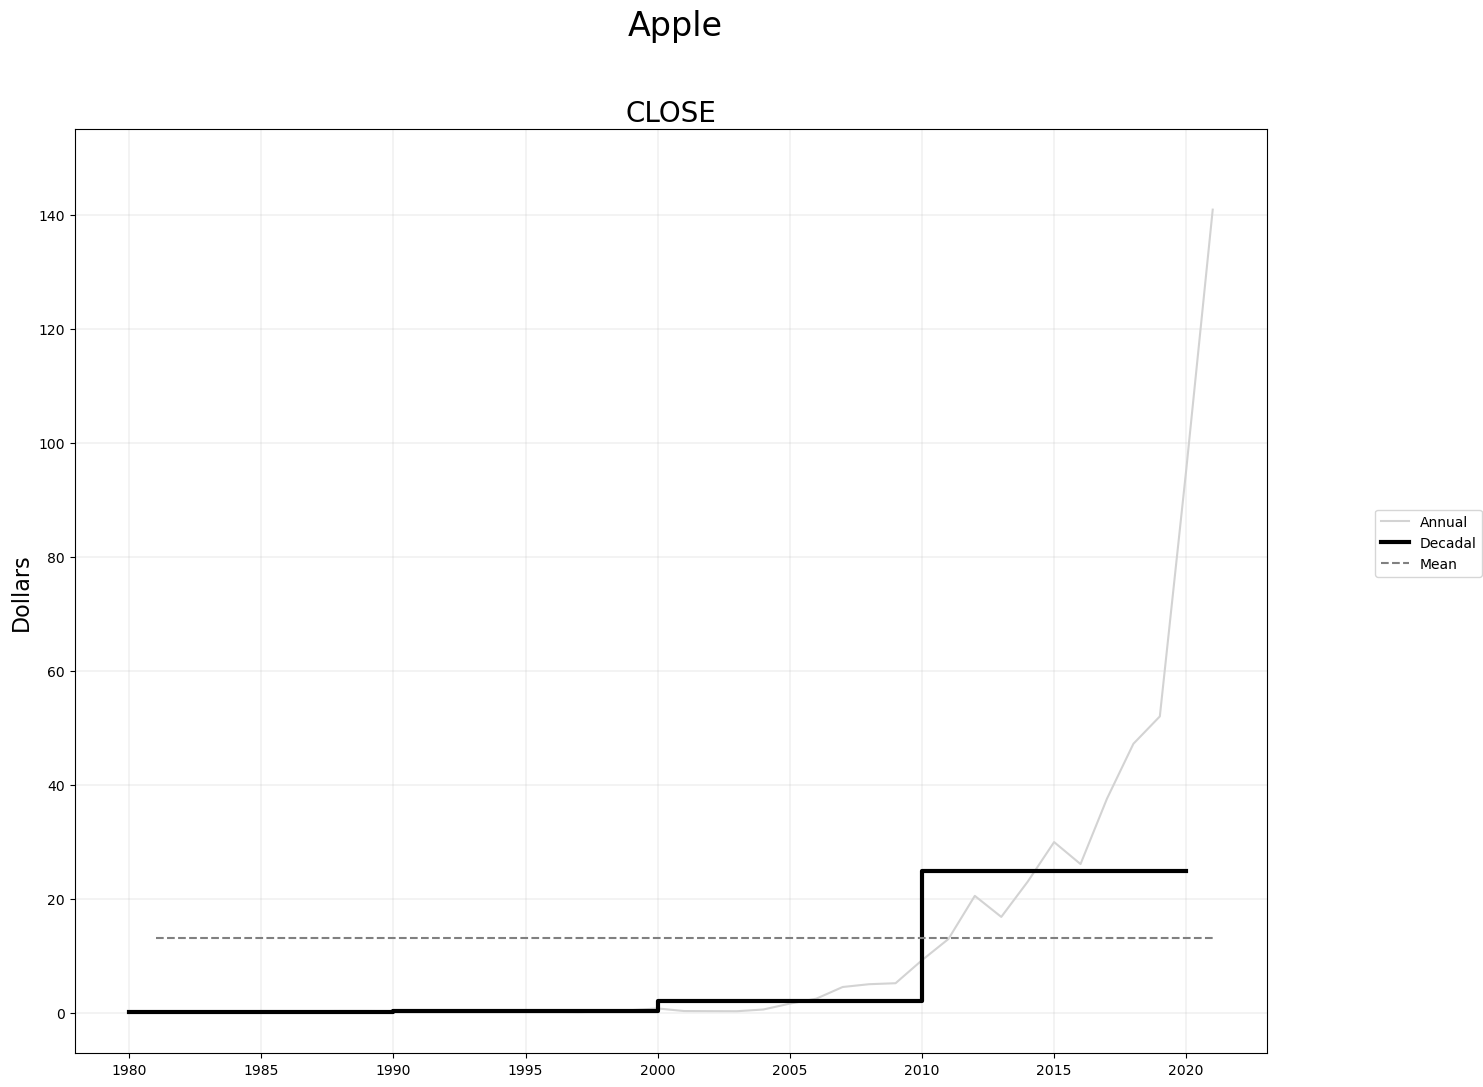

In [8]:
params = {
    'start date': pd.to_datetime("1980-01-01", format="%Y-%m-%d"),
    'columns': ['Close'],
    'units': ['Dollars'],
    'min decade records': 2200,
    'min annual records': 240
}
ts_plot(apple, "Apple", params)

### Two parameters

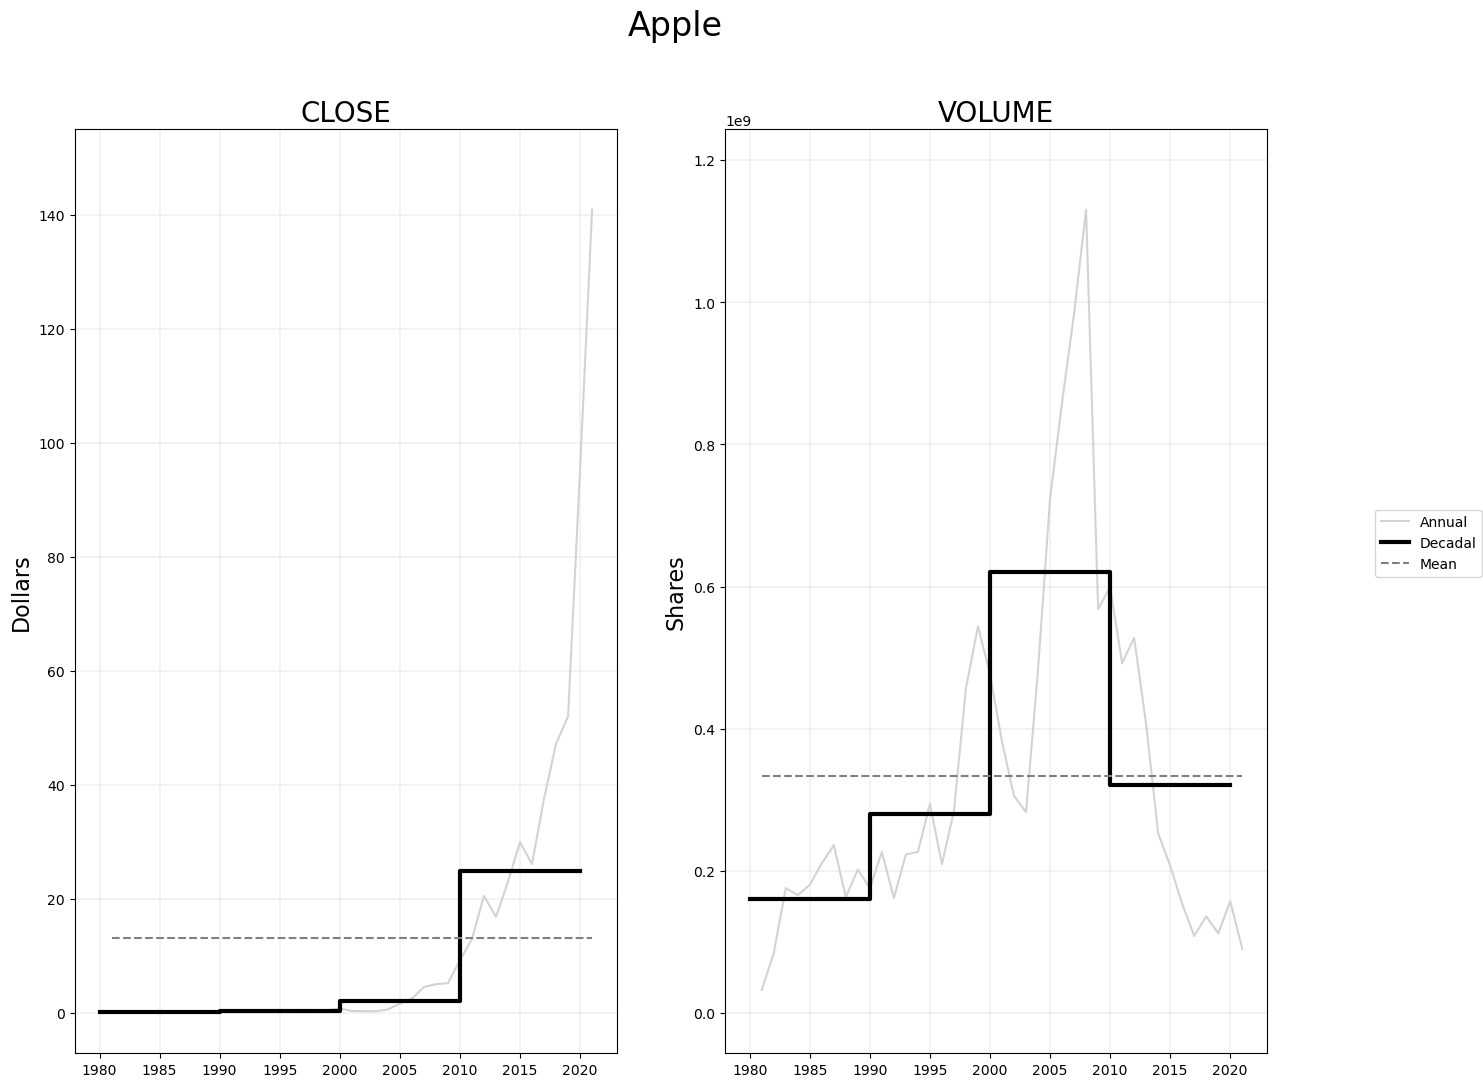

In [9]:
params = {
    'start date': pd.to_datetime("1980-01-01", format="%Y-%m-%d"),
    'columns': ['Close', 'Volume'],
    'units': ['Dollars', 'Shares'],
    'min decade records': 2200,
    'min annual records': 240
}

ts_plot(apple, "Apple", params)

# Russian Equipment Losses in the Ukraine

### https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war

In [10]:
ru = pd.read_csv(os.path.join('data', 'russia_losses_equipment.csv'), parse_dates = ['date'])
ru.set_index('date', drop = True, inplace = True)
ru.head()

,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles
date,,,,,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN
2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN
2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN


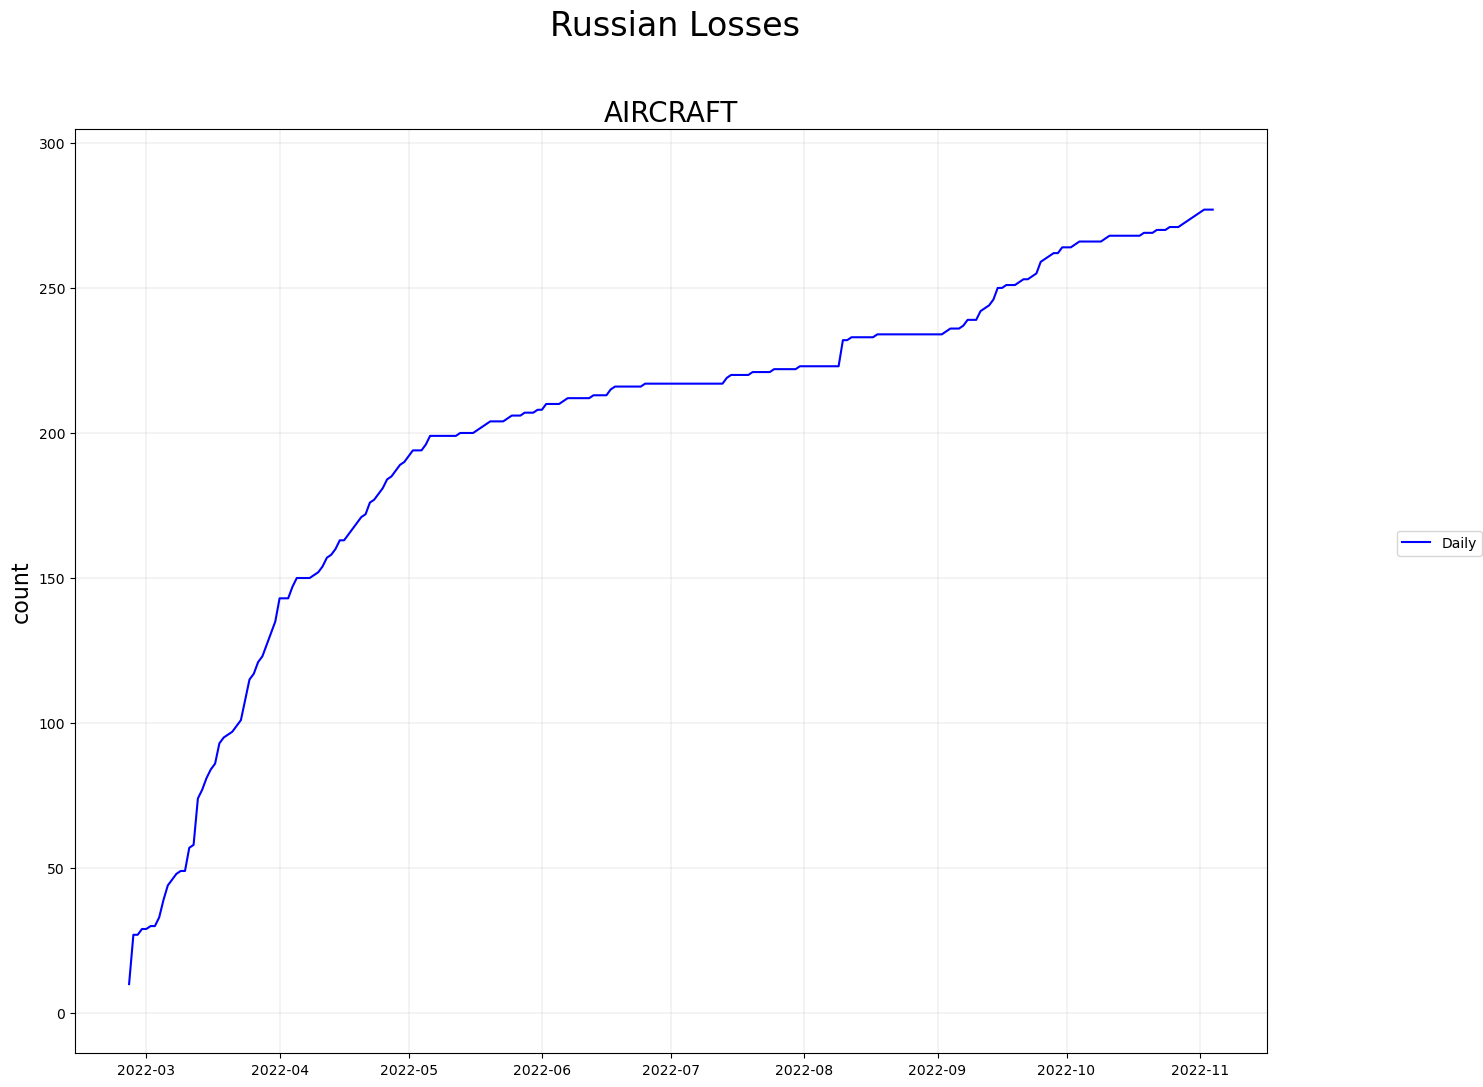

In [11]:
params = {
    'start date': pd.to_datetime("2022-01-01", format="%Y-%m-%d"),
    'columns': ['aircraft'],
    'units': ['count'],
    'min decade records': 2000,
    'min annual records': 20
}
ts_plot(ru, "Russian Losses", params)

### One TMIN with less than a year of data

In [12]:
test = pd.read_csv(os.path.join('data', 'test_short_col.csv'), parse_dates = ['date'])
test.set_index('date', drop = True, inplace = True)
test.head()

,station,latitude,longitude,elevation,name,prcp,snwd,tmax,tmin,doy,s_year_doy,s_year
date,,,,,,,,,,,,
1901-09-01,USW00027502,71.28703,-156.73938,8.1,"BARROW AIRPORT, AK US",0.0,NaN,33.0,NaN,244,63,1902
1901-09-02,USW00027502,71.28703,-156.73938,8.1,"BARROW AIRPORT, AK US",0.0,NaN,50.0,NaN,245,64,1902
1901-09-03,USW00027502,71.28703,-156.73938,8.1,"BARROW AIRPORT, AK US",0.0,0.0,39.0,NaN,246,65,1902
1901-09-04,USW00027502,71.28703,-156.73938,8.1,"BARROW AIRPORT, AK US",0.0,NaN,44.0,NaN,247,66,1902
1901-09-05,USW00027502,71.28703,-156.73938,8.1,"BARROW AIRPORT, AK US",8.0,NaN,78.0,NaN,248,67,1902


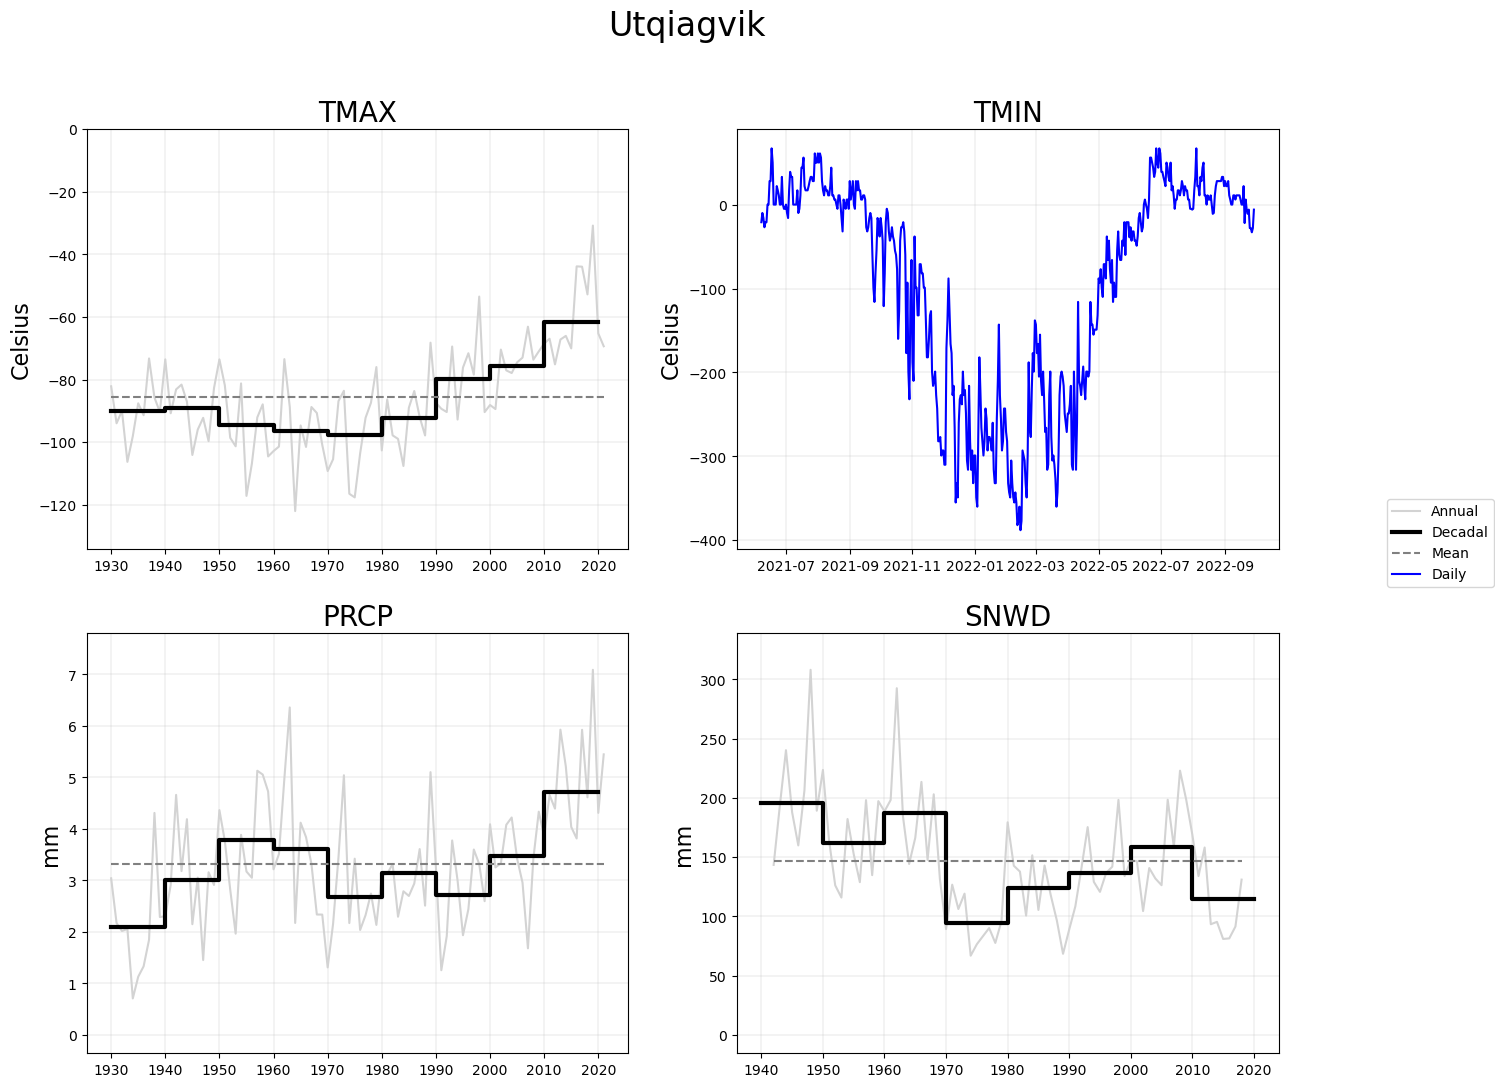

In [13]:
params = {
    'start date': pd.to_datetime("1930-01-01", format="%Y-%m-%d"),
    'columns': ['tmax', 'tmin', 'prcp', 'snwd'],
    'units': ['Celsius', 'Celsius', 'mm', 'mm'],
    'min decade records': 2920,
    'min annual records': 292
}

ts_plot(test, "Utqiagvik", params)

#  Issues/future work
* Improve the handling of columns with less than a years worth of data.
* Add groupby parameter
* Add figure saving feature